# Training a Classifier a Pytorch tutoriel 
<li>https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html</li>

## Loader

### Fonctions de Customisation de Dataset et de Loader

In [1]:
###### Librairies #######
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
#########################

/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from Loader_2D import CustomImageDataset

In [3]:
########## Path ##########
dataset_2D = './Database_2D/dataset_train'
dataset_test_2D = './Database_2D/dataset_test'
annotation_test = dataset_test_2D + '/annotation_test.txt'
annotation = dataset_2D + '/annotation.txt'


In [4]:
##### Image preprocessing #####
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.Resize(576),  # image batch, resize smaller edge to 576
        transforms.CenterCrop(576),  # image batch, center crop to square 576x576
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4098, 0.3934, 0.3934], std=[0.3189, 0.3121, 0.3026])        
])


### Instance des Datasets et Loaders

In [5]:
############## Paramètre ################
batch_size = 10


############## Train Part ###############
train_set = CustomImageDataset(
    annotations_file = annotation,
    img_dir = dataset_2D,
    transform=preprocess
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

############## Test Part ################

test_set = CustomImageDataset(
    annotations_file = annotation_test,
    img_dir = dataset_test_2D,
    transform=preprocess
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



### Try loader

/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this

torch.Size([3, 576, 576])


<function matplotlib.pyplot.show(close=None, block=None)>

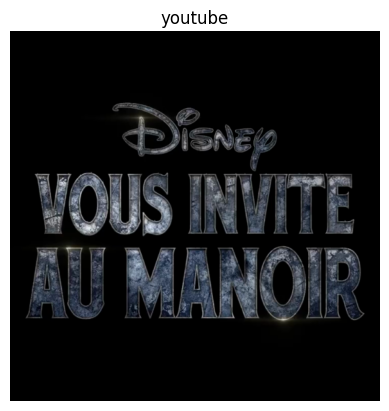

In [6]:
###### Fonction d'affichage ######
def denormalize(img_tensor):
        inverse_normalize = transforms.Normalize(
            mean=[-0.4098 / 0.3189, -0.3934 / 0.3121, -0.3934 / 0.3026],
            std=[1/0.3189, 1/0.3121, 1/0.3026]
        )
        return (inverse_normalize(img_tensor) * 255.).type(torch.uint8).permute(1, 2, 0).numpy()
# mean=[0.4098, 0.3934, 0.3934], std=[1/0.3189, 1/0.3121, 1/0.3026]
labels_map = {
    0: "tiktok" ,
    1:"vimizer",
    2: "youtube", 
}

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

img = images[0]
label = labels[0]
print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show


## Classifier

### Define the Convolutional Neural Network

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(318096, 120) # 120 -> 100 000
        self.fc2 = nn.Linear(120, 84) # 
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Autre solution avec un model existant 

In [8]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F

net = torchvision.models.resnet18(weights=None)
num_ftrs = net.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
net.fc = nn.Linear(num_ftrs, 3)

### Define a Loss function and optimizer

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [10]:
labels_total=[]
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        labels_numpy= labels.numpy()
        labels_total.extend(labels_numpy)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.3f}')
            running_loss = 0.0
        

print('Finished Training')



/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this

KeyboardInterrupt: 

In [ ]:
compteur_zero = labels_total.count(0)
compteur_un = labels_total.count(1)
compteur_deux = labels_total.count(2)

print("Nombre de zéros :", compteur_zero)
print("Nombre de uns :", compteur_un)
print("Nombre de deux :", compteur_deux)


Nombre de zéros : 108
Nombre de uns : 220
Nombre de deux : 142


### Test the network on the test data

#### First test on one frame 

/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this

torch.Size([3, 576, 576])


<function matplotlib.pyplot.show(close=None, block=None)>

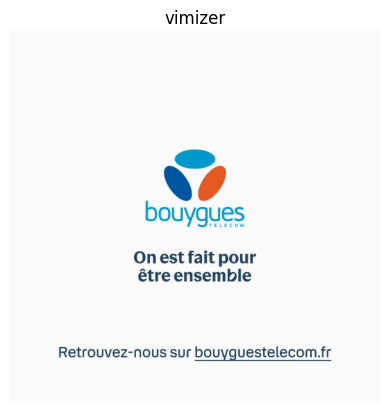

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

img = images[0]
label = labels[0]
print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

In [ ]:
print(labels_map[int(predicted[0].numpy())])


vimizer


#### Let us look at how the network performs on the whole dataset

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the  test images: {100 * correct // total} %')

/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this

Accuracy of the network on the  test images: 59 %


#### Result by class

In [ ]:
classes = ('tiktok','vimizer','youtube')
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zough/Documents/VAP/PFE/AI-for-coding-green-videos/IA/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this

Accuracy for class: tiktok is 0.0 %
Accuracy for class: vimizer is 100.0 %
Accuracy for class: youtube is 0.0 %
